# Atomic simulation with ASE

## Structural relaxation of the water molecule

Atomic Simulation Environment ([ASE](https://wiki.fysik.dtu.dk/ase/)) is a set of tools and Python modules for setting up, manipulating, visualizing and analyzing atomistic simulations. 

There are different modules intended to perform different tasks such as `ase.calculators` for calculating energies, forces and stresses, `ase.md` and `ase.optimize` modules for controlling the motion of atoms, constraints objects and filters for performing `nudged-elastic-band` calculations etc.

It provides an interface to very many [`calculators`](https://wiki.fysik.dtu.dk/ase/#supported-calculators) shown below:
<img src="images/ASE_calculators.png" width=500/>

### Atoms

The Atoms object defines a collection of atoms. 

Here is how to set up a $\mathrm{H_2O}$ molecule by directly specifying the position of the two hydrogen and one oxygen atoms (in units of Ångstrom):

In [1]:
from ase import Atoms # First impor the Atoms class
atoms = Atoms('HOH',
              positions=[[-0.5, 0, 0], [0, 1, 0], [0.5, 0, 0]])
#atoms.center(vacuum=3.0)

### Manipulation

The `Atoms` class provides many `methods` and `attributes` to carry out different operations like getting the positions of the atoms, calcualting the distances between them, etc..

The information as to which `methods` and `attributes` are available, can be obtained in two ways:

- Simply do `Atoms??` in a cell and see the result!
- `atoms` which is the instanct of the Atoms class also provides the aforementioned list by doing a double tap after `atoms.`!

For example, lets access the positions that we have set for the atoms

In [2]:
atoms.positions

array([[-0.5,  0. ,  0. ],
       [ 0. ,  1. ,  0. ],
       [ 0.5,  0. ,  0. ]])

Getting the distances between the atoms in the cell

In [3]:
atoms.get_all_distances()

array([[0.        , 1.11803399, 1.        ],
       [1.11803399, 0.        , 1.11803399],
       [1.        , 1.11803399, 0.        ]])

Setting new positions can be done by one of the `set_`ter method as follows

In [4]:
atoms_copy = atoms.copy()
print("Initial atoms_copy positions: \n", atoms_copy.get_positions())
atoms_copy.set_positions([[0, 0.6, 0],[0,1.1, 0], [0, 1.5, 0]]) # Set new positions
print("New atoms_copy positions: \n", atoms_copy.get_positions())
print("Original atoms positions: \n", atoms.get_positions())

Initial atoms_copy positions: 
 [[-0.5  0.   0. ]
 [ 0.   1.   0. ]
 [ 0.5  0.   0. ]]
New atoms_copy positions: 
 [[0.  0.6 0. ]
 [0.  1.1 0. ]
 [0.  1.5 0. ]]
Original atoms positions: 
 [[-0.5  0.   0. ]
 [ 0.   1.   0. ]
 [ 0.5  0.   0. ]]


### Visualize

The simplest way to visualize the atoms is the `view` function, which should bring up an interactive 3d viewer:

In [5]:
import ase.visualize as viz
viz.view(atoms, viewer='nglview') # ASE's default gui, opens an exteral window

### Adding calculator

In this overview we use the effective medium theory (EMT) calculator, as it is very fast and hence useful for getting started.

We can attach a calculator to the previously created Atoms objects:

In [6]:
from ase.calculators.emt import EMT
atoms.calc = EMT()

### Structure relaxation

Let’s use the `QuasiNewton` minimizer to optimize the structure of the distorted water molecule

In [7]:
from ase.optimize import QuasiNewton

# instantiate the QuasiNewton class to create the opt object and save the trajectory
opt = QuasiNewton(atoms, trajectory='io_data/opt.traj')

# Run the actual optimization till the maximum force acting between the atoms is less the a chosen fmax
opt.run(fmax=0.0005)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 00:02:58        2.287527*       3.2062
BFGSLineSearch:    1[  2] 00:02:58        2.127194*       2.0220
BFGSLineSearch:    2[  3] 00:02:58        1.992689*       2.8077
BFGSLineSearch:    3[  4] 00:02:58        1.906263*       0.5423
BFGSLineSearch:    4[  6] 00:02:58        1.891730*       0.3810
BFGSLineSearch:    5[  8] 00:02:58        1.879362*       0.0534
BFGSLineSearch:    6[ 10] 00:02:58        1.878938*       0.0382
BFGSLineSearch:    7[ 11] 00:02:58        1.878893*       0.0218
BFGSLineSearch:    8[ 12] 00:02:58        1.878884*       0.0025
BFGSLineSearch:    9[ 13] 00:02:58        1.878884*       0.0001


True

**Note**: The general documentation on [structure optimizations](https://wiki.fysik.dtu.dk/ase/ase/optimize.html#structure-optimizations) contains information about different algorithms, saving the state of an optimizer and other functionality which should be considered when performing expensive relaxations.

### Input Output

Writing the atomic positions to a file is done with the `write()` function:

In [8]:
import ase.io as io
io.write("io_data/h20.xyz", atoms)

This will write a file in the xyz-format. Possible formats are: <img src="images/ase_fileformats.png" width=300/>

Reading from a file is done like this:

In [9]:
from ase.io import read
new_atoms = read("io_data/h20.xyz")
new_atoms

Atoms(symbols='HOH', pbc=False, energies=..., forces=..., calculator=SinglePointCalculator(...))

### Visualizing the trajectory

Let's finally visualize the trajectory of our water molecule structure relaxation

The following command will give a pop-up window where you can see the subsequent relaxation images as a movie.

**Note**: It is commented out because in this share binder the gui wont open and I have saved the movie as gif and is already attached.

In [10]:
#!ase gui io_data/opt.traj

**What is the bond angle that you would expect after the relaxation??**
<img src="images/h20.gif" width=250 height=200>

## Equation of state (EOS)

This example is a simple illustration of how to get a marcoscopic quntiity using atomistic simulations

We can find the optimal lattice parameter and calculate the bulk modulus by doing an equation-of-state calculation. This means sampling the energy and lattice constant over a range of values to get the minimum, as well as the curvature $\left ( \dfrac{\partial^2 E}{\partial V^2} \right )$, which gives us the bulk modulus.

First, do a bulk calculation for different lattice constants:

In [11]:
import numpy as np

from ase import Atoms
from ase.io.trajectory import Trajectory
from ase.calculators.emt import EMT
import ase.visualize as viz

a = 4.0  # approximate lattice constant
b = a / 2
ag = Atoms('Ag',
           cell=[(0, b, b), (b, 0, b), (b, b, 0)],
           pbc=1,
           calculator=EMT())  # use EMT potential
cell = ag.get_cell()
print(f"Starting cell volume is {ag.get_volume()}")
viz.view(ag, viewer="nglview") # visualize formed unitcell

Starting cell volume is 15.999999999999998


If we want to make and view a supercell, this can be done using the repeat parameter in the view as follows:

In [12]:
#viz.view(ag, repeat=[2,2,2], viewer="nglview")

In [13]:
cell = ag.get_cell() # get the current cell
traj = Trajectory('io_data/Ag.traj', 'w') # create the traj object to save the trajectory at each cell dimension

# Run over range of values lower and higher than the starting value
for x in np.linspace(0.95, 1.05, 5):
    ag.set_cell(cell * x, scale_atoms=True) # scale the cell by a given amount
    ag.get_potential_energy() # get the potential energy for the given cell dimension
    traj.write(ag) # write the configuration

This will write a trajectory file containing five configurations of FCC silver for five different lattice constants. 

Now, analyse the result with the EquationOfState class:

100.14189241977189 GPa


<AxesSubplot:title={'center':'sj: E: -0.000 eV, V: 16.781 Å$^3$, B: 100.142 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

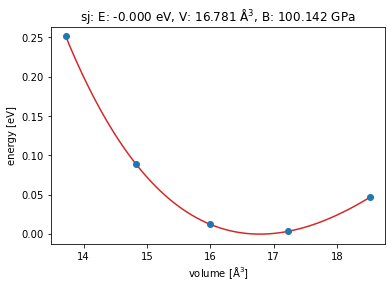

In [14]:
from ase.io import read
from ase.units import kJ
from ase.eos import EquationOfState

configs = read('io_data/Ag.traj@0:5')  # read 5 configurations

# Extract volumes and energies:
volumes = [ag.get_volume() for ag in configs]
energies = [ag.get_potential_energy() for ag in configs]

# instantiate the EquationOfState
eos = EquationOfState(volumes, energies)

# Use the fit() method to get the minimum energy and the corresponding  volume
v0, e0, B = eos.fit()
print(B / kJ * 1.0e24, 'GPa')
eos.plot('images/Ag-eos.png')

**If you have noticed, this all depends on a good starting point. What if we started at a cell volume value really far off from the minima??**